In [11]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import sys
from importlib import reload
import cv2
import json

print('Python | Pytorch | OpenCV versions: %s | %s | %s' %(sys.version, torch.__version__, cv2.__version__))

sys.path.append('/home/blanca/mnt/projects/')
import tools
from tools.utils import *
from tools.visuals import *

if __name__ == "__main__":
    print("lol")

Python | Pytorch | OpenCV versions: 3.7.0 (default, Jun 28 2018, 13:15:42) 
[GCC 7.2.0] | 0.4.1 | 3.4.3
lol


In [12]:
import os, sys
import xmltodict
from pathlib import Path
import numpy as np
from skimage import io
import operator
from functools import reduce


def xy_xy2ulxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = x[0]
    y[1] = x[1]
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()

def xy_xy2bbxy_wh(x):  # Convert bounding box format from [x1, y1, x2, y2] to [x, y, w, h]
    y = np.zeros(len(x))
    y[0] = (x[0] + x[2]) / 2
    y[1] = (x[1] + x[3]) / 2
    y[2] = x[2] - x[0]
    y[3] = x[3] - x[1]
    return y.tolist()
     
def adjust_polygon_format(o_polygon):
    polygon_list = []
    co_k_x = [i for i in list(o_polygon.keys()) if i[0] == 'x']
    co_k_x = sorted(co_k_x, key=lambda x: int(x[1:]))
    for i in co_k_x:
        ix = i[1:]
        xk, yk = i, 'y' + ix
        polygon_list.append([float(o_polygon[xk]), float(o_polygon[yk])])
        
    polygon_list = reduce(operator.add, polygon_list)
    
    return polygon_list

## convert fumehood dv

In [13]:
def create_mcnn_dataset(ann_files, cat_file):

    with open(str(cat_file), 'r') as f:
        cat_data = [i.strip() for i in f.readlines()]

    cat_dic = {i:cat_data[i] for i in range(len(cat_data))}

    ### CATEGORIES ###

    categories = [{
        "id" : i, #int, 
        "name" : j, #str, 
        "supercategory" : j, #str,
    } for i, j in cat_dic.items()]

    ### DATASET ###

    info = {
        "year" : '2018', 
        "version" : '1', 
        "description" : 'fumehood', 
        "contributor" : 'v7', 
        "url" : 'none', 
        "date_created" : '2018/09/20',
    }

    dataset = {

        "info" : info, 
        "images" : [],       # image
        "annotations" : [],  # annotation
        "licenses" : [],     # license
        "categories": categories
    }

    count_i = 0
    count_o = 0
    total_dv_files = 0
    for file in ann_files:
        with open(str(file)) as fd:
            doc = xmltodict.parse(fd.read())

            count_i += 1
            # creating an image: 
            data = doc['annotation']
            # image
            folder = data['folder']
            filename = data['filename']
            url = folder + '/' + filename
            
            im_name = str(file).split('/')[-1].split('.')[0] + '.png'    # filename.split('.')[0]
            width = int(data['size']['width'])
            height = int(data['size']['height'])
            try: objects = data['object']
            except: continue

            image_dic = {
                "id" : count_i, #int, 
                "width" : width, #int, 
                "height" : height, #int, 
                "file_name" : im_name, #str, 
                "license" : 0, #int, 
                "flickr_url" : 'no-flickr_url', #str, 
                "coco_url" : url, #str, 
                "date_captured" : "2018-20-01 00:00:00", #datetime,
            }

            license = {
                "id" : count_i, #int, 
                "name" : im_name, #str, 
                "url" : 'url', #str,
            }

            dataset['images'].append(image_dic)
            dataset['licenses'].append(image_dic)

            # parsing objects annotations
            if isinstance(objects, dict): objects = [objects]

            for i in objects:
                count_o += 1

                o_cat_name = i['name']
                o_cat_ix = cat_data.index(o_cat_name)
                o_polygon = i['polygon']
                o_polygon = [adjust_polygon_format(o_polygon)]
                o_bbox = [i['bndbox']['xmin'], i['bndbox']['ymin'], i['bndbox']['xmax'], i['bndbox']['ymax']]
                o_bbox = xy_xy2ulxy_wh([int(i) for i in o_bbox])
                try: o_dv_angle = i['direction']['angle']; total_dv_files += 1
                except: o_dv_angle = None
                
                annotation = {
                    "id" : count_o, #int, 
                    "image_id" : count_i, #int, 
                    "category_id" : o_cat_ix, #int, 
                    "segmentation" : o_polygon, # polygon format or list 
                    "area" : 33., #float, 
                    "bbox" : o_bbox, #[x, y, width, height], 
                    "iscrowd" : 0, # 0 or 1,
                    "angle" : float(o_dv_angle) if isinstance(o_dv_angle, str) else None, # float - directional vector - [-pi, pi],
                    
                    # attributes
                    "open_bottle": i['attributes']['open_bottle'],
                    "in_hand": i['attributes']['in_hand'],
                    "off_table": i['attributes']['off_table'],
                    "cap_on_top": i['attributes']['cap_on_top'],
                    "pipette_inside": i['attributes']['pipette_inside'],
                    "pipette_pressed": i['attributes']['pipette_pressed'],
                    "occluded": i['attributes']['occluded'],
                }

                dataset['annotations'].append(annotation)
    
    print(total_dv_files)
    return dataset

#### whole set

In [25]:
xml_annotations_paths = [
#                         '/home/blanca/mnt/data/fh+/Annotations_with_directions', 
                        '/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes'
]

ann_files = []
for xml_annotations_path in xml_annotations_paths:
    path = Path(xml_annotations_path)
    ann_files.append(np.array(list(path.glob("*"))))
    
[print(i.shape) for i in ann_files]
ann_files = np.concatenate(ann_files, axis=0)
cat_file = path.parent / Path('fumehood.names') # categories names file path

(1601,)


In [26]:
# len(dataset_dv['images'])

In [27]:
total_size = len(ann_files)
dataset = create_mcnn_dataset(ann_files, cat_file)
print(len(dataset['images']))

3293
1599


In [28]:
# filtering images w/o dv
dataset_dv = dataset.copy()
images_list = [ao['image_id'] for ao in dataset_dv['annotations'] if isinstance(ao['angle'], float)]
images_dv = [imo for imo in dataset_dv['images'] if imo['id'] in images_list]
annotations_dv = [ao for ao in dataset_dv['annotations'] if isinstance(ao['angle'], float)]
print(len(images_list), len(images_dv), len(annotations_dv))

print(len(dataset_dv['annotations']), len(dataset_dv['images']), len(dataset_dv['annotations']))
dataset_dv['images'] = images_dv
dataset_dv['annotations'] = annotations_dv
print(len(dataset_dv['annotations']), len(dataset_dv['images']), len(dataset_dv['annotations']))

3293 1590 3293
5797 1599 5797
3293 1590 3293


In [210]:
len(np.unique(images_list))

# create dataset and shuffle
ds = {}
for imo in dataset_dv['images']:
    iid, url = imo['id'], imo['coco_url']
    anns = [ao for ao in dataset_dv['annotations'] if ao['image_id'] == iid] #and ao['angle'] is not None] 
    if len(anns) == 0: print('anns empty - double check', iid, url); break
    ds[iid] = {'url': url, 
#                                 'im': io.imread(url), # cv2.imread(str(input_dir / imo['file_name'])), # 
                                'ann': anns,
                            }
len(ds)

ss_ix = [list(ds.keys())[i] for i in np.random.permutation(len(ds))]
len(ss_ix)
# ss_ixs = {'train': ss_ix[:len(ss_ix) * 4 // 5], 'eval': ss_ix[len(ss_ix) * 4 // 5:]}


# ds_ = {i: j for i, j in dataset.items() if i in ss_ixs['train']}   
# print('Initialized "%s" dataset with %d images-label pairs' %('train', len(ds_)))

1167

In [29]:
out_file = '/home/blanca/mnt/data/fh+/annotations/annotations_with_directions.json'

with open(out_file, 'w') as f:
    json.dump(dataset_dv, f, indent=1)

In [14]:
out_file = '/home/blanca/mnt/data/fh+/annotations/annotations_with_directions.json'

with open(out_file, 'w') as f:
    json.dump(dataset, f, indent=1)

[1205, 548]
1.262383923107047 1.262383923107047 72.32927091920124
0.9528166794884142 0.3035463313708018
1265.7092662741604 357.4366641023172
[1224, 623]
2.3727151601056358 -0.7688774934841576 -44.05343533923968
-0.6953289408197376 0.7186916334969413
1367.7383266993884 762.0657881639476
[840, 768]
2.0568838411559125 -1.0847088124338808 -62.14923695310901
-0.8841674177753971 0.4671701802816469
933.4340360563294 944.8334835550794
[862, 617]
-1.1217541294635849 -1.1217541294635849 -64.27177726963517
-0.9008633004096076 0.4341028840898308
948.8205768179662 797.1726600819215


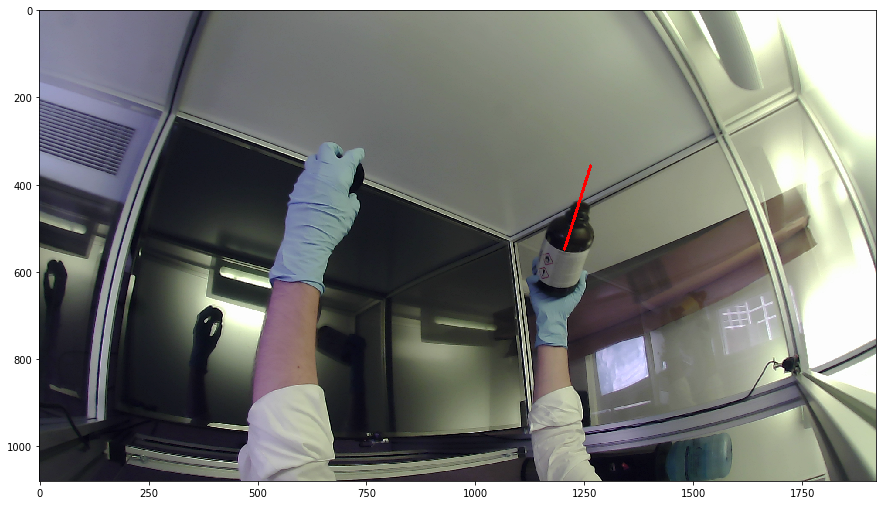

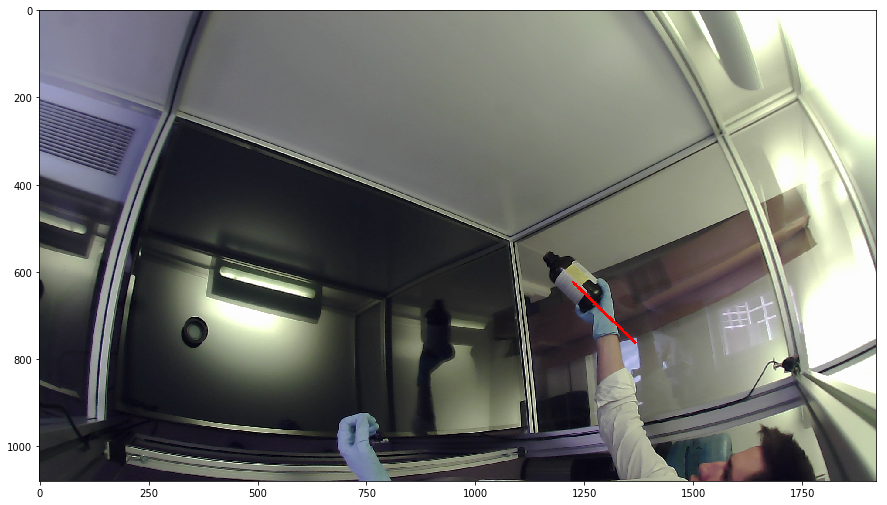

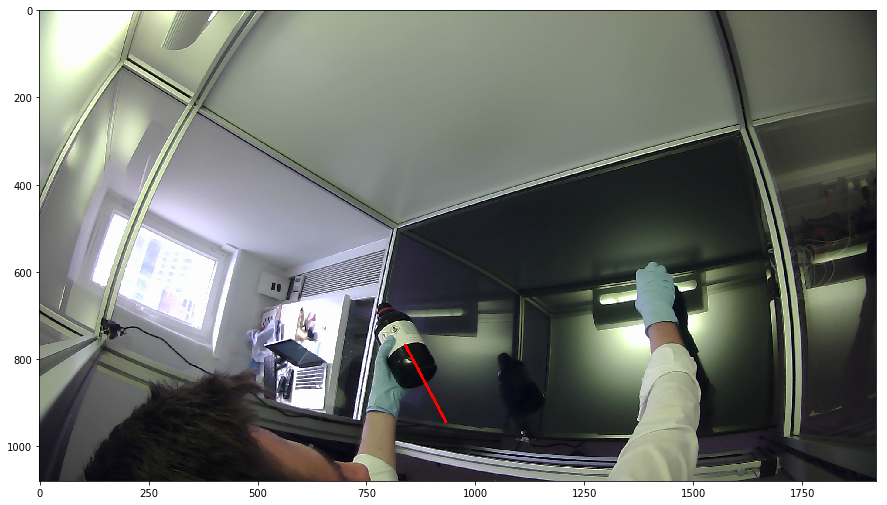

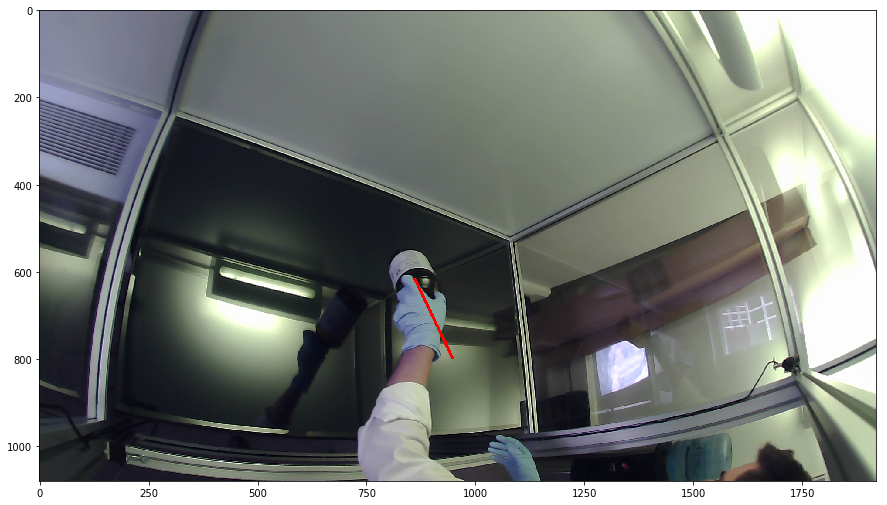

In [18]:
from skimage import io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

for i in [1, 4 ,7, 9]:
    imo = [imo for imo in dataset_dv['images'] if imo['id'] == i][0]
    anns = [ao for ao in dataset_dv['annotations'] if ao['image_id'] == imo['id']][0]

    def bbcc_from_xxww(boxes):
        cc = np.zeros( 2)
        cc[0] = boxes[0] + boxes[2] / 2
        cc[1] = boxes[1] + boxes[3] / 2

        return cc

    bbcc = [int(i) for i in bbcc_from_xxww(np.array(anns['bbox']))]
    print(bbcc)

    angle = np.arctan(np.sin(anns['angle']) / np.cos(anns['angle']))
    print(anns['angle'], angle, angle * 180 / np.pi)
    im = io.imread(imo['coco_url'])
    print(np.sin(angle), np.cos(angle))
    dvlx, dvly = bbcc[0] + np.cos(angle) * 200, bbcc[1] - np.sin(angle) * 200
    print(dvlx, dvly)
    cv2.line(im, (bbcc[0], bbcc[1]), (int(dvlx), int(dvly)), (255,0,0), 5)
    plt.figure(figsize=(15,15))
    plt.imshow(im)

#### train-val sets

In [7]:
xml_annotations_path = Path('/home/blanca/mnt/data/fh+/Annotations')
path = Path(xml_annotations_path)
ann_files = np.array(list(path.glob("*")))
cat_file = path.parent / Path('fumehood.names') # categories names file path

In [8]:
total_size = len(ann_files)
train_set_size = int(total_size * 0.9)
val_set_size = int(total_size * 0.1)
val_set_ix = np.random.randint(0, total_size, val_set_size)
val_ann_files = np.array(ann_files)[val_set_ix]
train_ann_files = np.setdiff1d(ann_files, val_ann_files)

train_dataset = create_mcnn_dataset(train_ann_files, cat_file)
val_dataset = create_mcnn_dataset(val_ann_files, cat_file)

print(len(train_dataset['images']), len(val_dataset['images']))

1497 165


#### saving as .json

In [9]:
out_file_train = '/home/blanca/mnt/data/fh+/annotations/annotations_train.json'
out_file_val = '/home/blanca/mnt/data/fh+/annotations/annotations_val.json'

with open(out_file_train, 'w') as f:
    json.dump(train_dataset, f, indent=1)

with open(out_file_val, 'w') as f:
    json.dump(val_dataset, f, indent=1)

#### how to print the dv

[1205, 548]
1.262383923107047
0.9528166794884142 0.3035463313708018
1265.7092662741604 357.4366641023172


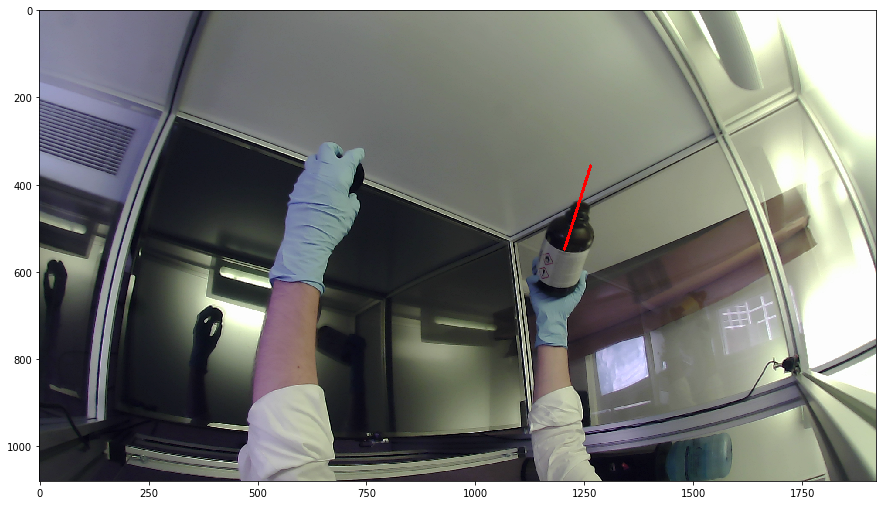

In [99]:
imo = [imo for imo in dataset['images'] if imo['id'] == 1][0]
anns = [ao for ao in dataset['annotations'] if ao['image_id'] == imo['id']][0]

from skimage import io
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

def bbcc_from_xxww(boxes):
    cc = np.zeros( 2)
    cc[0] = boxes[0] + boxes[2] / 2
    cc[1] = boxes[1] + boxes[3] / 2
    
    return cc

bbcc = [int(i) for i in bbcc_from_xxww(np.array(anns['bbox']))]
print(bbcc)

angle = np.arctan(np.sin(anns['angle']) / np.cos(anns['angle']))
print(angle)
im = io.imread(imo['coco_url'])
print(np.sin(angle), np.cos(angle))
dvlx, dvly = bbcc[0] + np.cos(angle) * 200, bbcc[1] - np.sin(angle) * 200
print(dvlx, dvly)
cv2.line(im, (bbcc[0], bbcc[1]), (int(dvlx), int(dvly)), (255,0,0), 5)
plt.figure(figsize=(15,15))
plt.imshow(im)

In [101]:
np.arctan(np.sin(-np.pi/4) / np.cos(-np.pi/4)) * 180 / np.pi

-45.0

In [48]:
p = '/home/blanca/recordings/'
folders = ['Images0', 'Images1', 'Images2']
[os.makedirs(p + f, exist_ok=True) for f in folders]

[None, None, None]

In [54]:
for f in folders:
    out_p = p + f
    file = p + f[-1]+'.mp4'
    vidcap = cv2.VideoCapture(file)
    success, image = vidcap.read()
    count = 0
    while success:
        count += 1
        width = 10
        im_name = str(count).zfill(width) + '.jpg'
        cv2.imwrite(out_p + '/' + im_name, image)     # save frame as JPEG file      
        success, image = vidcap.read()
        print('Wrote a new frame as: ', out_p + '/' + im_name)
# 449, 449, 450

Wrote a new frame as:  /home/blanca/recordings/Images0/0000000001.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000002.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000003.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000004.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000005.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000006.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000007.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000008.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000009.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000010.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000011.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000012.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000013.jpg
Wrote a new frame as:  /home/blanca/recordings/Images0/0000000014.jpg
Wrote a new frame as

#### cheching model output

(1080, 1920, 3)


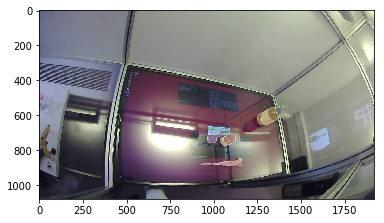

In [14]:
model_path = '/home/blanca/mnt/projects/vectors/classifier/classifier/checkpoint.pth.tar'
model = define_net(conf_file, input_nc, output_nc, ngf, model='encoder', norm='batch', n_classes=label_size,
                               n_downsample_global=n_downsample_global, padding_type=padding_type)
model.load_state(model_path)



## Create Video

In [25]:
import cv2
import os
import numpy as np

suffix = '2'

input_dir = '/home/blanca/mnt/tmp/r%s/' %suffix
output_dir = '/home/blanca/mnt/Detectron_VisOutput/'
output_name = output_dir + 'recordings-%s-rcnn-b256_10e3.avi' %suffix

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".jpg")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 15.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

In [13]:
import cv2
import os
import numpy as np

input_dir = '/home/blanca/mnt/projects/detector/mask-rcnn.pytorch/output/R-101/tmp/camara_output/'
output_dir = '/home/blanca/mnt/projects/detector/mask-rcnn.pytorch/output/R-101/tmp/'
output_name = output_dir + 'camara_output.avi'

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".jpg")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 10.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

#### colormap

In [55]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

import numpy as np


def colormap(rgb=False):
    color_list = np.array(
        [
            0.000, 0.447, 0.741,
            0.850, 0.325, 0.098,
            0.929, 0.694, 0.125,
            0.494, 0.184, 0.556,
            0.466, 0.674, 0.188,
            0.301, 0.745, 0.933,
            0.635, 0.078, 0.184,
            0.300, 0.300, 0.300,
            0.600, 0.600, 0.600,
            1.000, 0.000, 0.000,
            1.000, 0.500, 0.000,
            0.749, 0.749, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 1.000,
            0.667, 0.000, 1.000,
            0.333, 0.333, 0.000,
            0.333, 0.667, 0.000,
            0.333, 1.000, 0.000,
            0.667, 0.333, 0.000,
            0.667, 0.667, 0.000,
            0.667, 1.000, 0.000,
            1.000, 0.333, 0.000,
            1.000, 0.667, 0.000,
            1.000, 1.000, 0.000,
            0.000, 0.333, 0.500,
            0.000, 0.667, 0.500,
            0.000, 1.000, 0.500,
            0.333, 0.000, 0.500,
            0.333, 0.333, 0.500,
            0.333, 0.667, 0.500,
            0.333, 1.000, 0.500,
            0.667, 0.000, 0.500,
            0.667, 0.333, 0.500,
            0.667, 0.667, 0.500,
            0.667, 1.000, 0.500,
            1.000, 0.000, 0.500,
            1.000, 0.333, 0.500,
            1.000, 0.667, 0.500,
            1.000, 1.000, 0.500,
            0.000, 0.333, 1.000,
            0.000, 0.667, 1.000,
            0.000, 1.000, 1.000,
            0.333, 0.000, 1.000,
            0.333, 0.333, 1.000,
            0.333, 0.667, 1.000,
            0.333, 1.000, 1.000,
            0.667, 0.000, 1.000,
            0.667, 0.333, 1.000,
            0.667, 0.667, 1.000,
            0.667, 1.000, 1.000,
            1.000, 0.000, 1.000,
            1.000, 0.333, 1.000,
            1.000, 0.667, 1.000,
            0.167, 0.000, 0.000,
            0.333, 0.000, 0.000,
            0.500, 0.000, 0.000,
            0.667, 0.000, 0.000,
            0.833, 0.000, 0.000,
            1.000, 0.000, 0.000,
            0.000, 0.167, 0.000,
            0.000, 0.333, 0.000,
            0.000, 0.500, 0.000,
            0.000, 0.667, 0.000,
            0.000, 0.833, 0.000,
            0.000, 1.000, 0.000,
            0.000, 0.000, 0.167,
            0.000, 0.000, 0.333,
            0.000, 0.000, 0.500,
            0.000, 0.000, 0.667,
            0.000, 0.000, 0.833,
            0.000, 0.000, 1.000,
            0.000, 0.000, 0.000,
            0.143, 0.143, 0.143,
            0.286, 0.286, 0.286,
            0.429, 0.429, 0.429,
            0.571, 0.571, 0.571,
            0.714, 0.714, 0.714,
            0.857, 0.857, 0.857,
            1.000, 1.000, 1.000
        ]
    ).astype(np.float32)
    color_list = color_list.reshape((-1, 3)) * 255
    if not rgb:
        color_list = color_list[:, ::-1]
    return color_list

In [56]:
color_list = colormap(rgb=True) / 255


In [58]:
mask_color_id = 0
for i in range (20):
    color_mask = color_list[mask_color_id % len(color_list), 0:3]
    mask_color_id += 1
    print(color_mask)

[0.    0.447 0.741]
[0.85  0.325 0.098]
[0.929 0.694 0.125]
[0.494 0.184 0.556]
[0.466 0.674 0.188]
[0.301 0.745 0.933]
[0.635 0.078 0.184]
[0.3 0.3 0.3]
[0.6 0.6 0.6]
[1. 0. 0.]
[1.  0.5 0. ]
[0.749 0.749 0.   ]
[0. 1. 0.]
[0. 0. 1.]
[0.667 0.    1.   ]
[0.333 0.333 0.   ]
[0.333 0.667 0.   ]
[0.333 1.    0.   ]
[0.667 0.333 0.   ]
[0.667 0.667 0.   ]


In [60]:
classes = cat_dic
classes

{0: 'beaker',
 1: 'bottle',
 2: 'flask',
 3: 'bare_hand',
 4: 'glove_hand',
 5: 'pipette',
 6: 'pipette_label',
 7: 'bottle_cap'}

In [62]:
color_dict = {
    '__background__': [0.   , 0.447, 0.741],
    'beaker':         [0.85 , 0.325, 0.098],
    'bottle':         [0.929, 0.694, 0.125],
    'flask':          [0.494, 0.184, 0.556],
    'bare_hand':      [0.466, 0.674, 0.188],
    'glove_hand':     [0.301, 0.745, 0.933],
    'pipette':        [0.635, 0.078, 0.184],
    'pipette_label':  [0.3  , 0.3  , 0.3  ],
    'bottle_cap':     [0.6  , 0.6  , 0.6  ],
}

In [65]:
mask_color_id = 0
for i in range (9):
    color_mask = color_list[mask_color_id % len(color_list), 0:3]
    mask_color_id += 1
    color_mask_fixed = color_dict[i]
    print(color_mask, color_mask_fixed)

[0.    0.447 0.741] [0.0, 0.447, 0.741]
[0.85  0.325 0.098] [0.85, 0.325, 0.098]
[0.929 0.694 0.125] [0.929, 0.694, 0.125]
[0.494 0.184 0.556] [0.494, 0.184, 0.556]
[0.466 0.674 0.188] [0.466, 0.674, 0.188]
[0.301 0.745 0.933] [0.301, 0.745, 0.933]
[0.635 0.078 0.184] [0.635, 0.078, 0.184]
[0.3 0.3 0.3] [0.3, 0.3, 0.3]
[0.6 0.6 0.6] [0.6, 0.6, 0.6]


In [11]:
# pytorch model 
import cv2
import os
import numpy as np

suffix = '2'

input_dir = '/home/blanca/mnt/projects/detector/mask-rcnn.pytorch/output/R-101/tmp/r%s' %suffix 
output_dir = '/home/blanca/mnt/projects/detector/R-101-mask-output/tmp/'
output_name = output_dir + 'torch_r%s.avi' %suffix

images = sorted([img for img in np.sort(os.listdir(input_dir)) if img.endswith(".png")])

frame = cv2.imread(os.path.join(input_dir, images[0]))
height, width, layers = frame.shape

# Define the codec and create VideoWriter object
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter(output_name, fourcc, 10.0, (width, height))

for image in images:
    video.write(cv2.imread(os.path.join(input_dir, image)))

cv2.destroyAllWindows()
video.release()

#### Download images from annotations path

In [36]:
# move to utils
import xmltodict
from skimage import io
from pathlib import Path

def download_images_and_parse_labels(annotations_path, output_path, save_images=True): 
    files, nO_files = 0, 0
    path = Path(annotations_path)
    ann_files = list(path.glob("*")) 
    cat_file = Path('/home/blanca/mnt/data/fh+') / Path('fumehood.names') # categories names file path
    
    with open(str(cat_file), 'r') as f:
        cat_file = [i.strip() for i in f.readlines()]
    
    dataset = {} # store all dataset labels in a dic (for now) - format {m_name: {image: np, label: list}
    for file in ann_files:
        with open(str(file)) as fd:
            doc = xmltodict.parse(fd.read())

        data = doc['annotation']
        folder = data['folder']
        try : objects = data['object']
        except: 
            nO_files += 1
            print('No object labeled in file %s' %file)
            continue
        filename = data['filename']
#         session_type = folder.split('/')[-2]
#         session = folder.split('/')[-1]
        im_name = str(file).split('/')[-1].split('.')[0] + '.png'
        
        # retrieve the image
        url = folder + '/' + filename
        im = io.imread(url)
        if save_images: io.imsave(output_path + im_name, im)
        
        # retrieve and parse the label (each 'label' - multiple annotations: one image multiple labels)
        label = []
        if isinstance(objects, dict): objects = [objects]
        for i in objects:
            cat_name = i['name']
            polygon = i['polygon']
            bbox = (i['bndbox']['xmin'], i['bndbox']['ymin'], i['bndbox']['xmax'], i['bndbox']['ymax'])
            cat = [cat_file.index(cat_name)]
            lab = np.array(np.concatenate([cat, bbox]), dtype='float32')
            label.append(lab)
        
        files += 1
        if im_name in dataset: print(dataset[im_name]['file'], file)
        dataset[im_name] = {'image': im, 'label': label, 'file': file}
    # save the labels in txt files and read from them?
    return dataset, files, nO_files, len(ann_files)

input_path = '/home/blanca/mnt/data/session_14/'
output_path = '/home/blanca/mnt/data/images_/'
dataset, files, nO_files, _ = download_images_and_parse_labels(input_path, output_path)
nO_files, _

(0, 781)

In [7]:
import numpy as np
import torch
import torch.nn.functional as F
a = np.array([[ 1, 10, 11, 15,  0,  0,  0,  0,  0,  0],
 [ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0]])
print(a.shape, a)

a = np.pad(a, [(0, 256 - a.shape[0]), (0, 0)], mode='constant', constant_values=0)
print(a, a.shape)

(2, 10) [[ 1 10 11 15  0  0  0  0  0  0]
 [ 5  0  0  0  0  0  0  0  0  0]]
[[ 1 10 11 ...  0  0  0]
 [ 5  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]] (256, 10)


In [59]:
n_classes = 16
label_ = np.zeros((256, n_classes), dtype=np.uint32)
# label = np.array([ 5, 10, 0,  0,  0,  0,  0,  0,  0,  0])
label = a
# print(label_.shape)
for i in range(label.shape[0]):
    print(i)
    print(np.where(label[i,:] > 0))
    for j in np.where(label[i,:] > 0):
        print(j)
        label_[i, label[i,j]] = 1
# print(label_.shape)
# label_[255]

0
(array([0, 1, 2, 3]),)
[0 1 2 3]
1
(array([0]),)
[0]


In [69]:
t = torch.tensor([[0, 1, 2, 3], [0, 6, 2, 3]])
t.topk(3, dim=1)

(tensor([[3, 2, 1],
         [6, 3, 2]]), tensor([[3, 2, 1],
         [1, 3, 2]]))

In [73]:
t = torch.tensor([0.0000, 0.0039, 0.0039, 0.0039, 0.0078, 0.0039, 0.0195, 0.0508, 0.0547,
        0.0781, 0.1016, 0.1367, 0.1875, 0.1172, 0.1445, 0.0859], device=0)
t.mean()

tensor(0.0625, device='cuda:0')

In [9]:
import numpy as np
n_classes = 10
np.eye(n_classes)[6]
F.binary_cross_entropy_with_logits()

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [192]:
preds = torch.tensor([[-0.4870, -0.2106, -0.5510,  0.2775, -0.8883, -1.8863, -0.9451],
        [-1.5769,  0.0684, -0.6772, -0.3703,  0.0523, -1.6505, -0.5008]])
labs =  torch.tensor([[0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])
# Loss: tensor(0.5400)
                     
loss = F.binary_cross_entropy_with_logits(preds, labs)          

torch.sigmoid(preds) > 0.5
preds.sigmoid()

tensor([[0.3806, 0.4475, 0.3656, 0.5689, 0.2915, 0.1317, 0.2799],
        [0.1712, 0.5171, 0.3369, 0.4085, 0.5131, 0.1610, 0.3774]])

In [136]:
# preds_50 = (torch.sigmoid(preds) > 0.5).float()
# print(labs, preds_50)

# # accuracy_attbs_0 = cls_score[:, n_classes:].eq(rois_attbs).float().mean(dim=1).mean()
# # accuracy_attbs_1 = cls_score[:, n_classes:].eq(rois_attbs).float().sum()
# # accuracy_attbs_2 = attbs_preds.sum() / cls_score[:, n_classes:].sum(dim=1)

# accuracy_attbs_total = preds_50.eq(labs).float().mean()
# accuracy_attbs_recall = (preds_50 > 0).eq(labs > 0).float().sum()
# # accuracy_attbs_2 = preds.sum() / labs.sum(dim=1)

# accuracy_attbs_0, accuracy_attbs_1

In [47]:
torch.sigmoid(preds), preds_50

(tensor([[0.3806, 0.4475, 0.3656, 0.5689, 0.2915, 0.1317, 0.2799],
         [0.1712, 0.5171, 0.3369, 0.4085, 0.5131, 0.1610, 0.3774]]),
 tensor([[0, 0, 0, 1, 0, 0, 0],
         [0, 1, 0, 0, 1, 0, 0]], dtype=torch.uint8))

In [160]:
labs, preds_50

(tensor([[0., 1., 0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0., 1., 0.]]), tensor([[0., 1., 0., 1., 0., 0., 1.],
         [0., 1., 0., 0., 1., 1., 0.]]))

In [159]:
preds_50.eq(labs).float().mean(dim=1)

len(np.where((preds_50.eq(labs)) & (labs == 1.))[1]) / (labs == 1.).float().sum()

tensor(1.)

In [188]:
preds = torch.tensor([[-0.4870, 0.0006, -0.5510,  0.2775, -0.8883, -1.8863, 0.9451],
        [-1.5769,  0.0684, -0.6772, -0.3703,  0.0523, -1.6505, -0.5008]])
labs =  torch.tensor([[0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1., 0.]])
preds_50 = (torch.sigmoid(preds) > 0.5).float()

# recall with tensors:
Tp = (labs == 1.).float().sum(dim=1)
tp_Tp = len(np.where((preds_50.eq(labs)) & (labs == 1.))[1]) / Tp
print(Tp)

# torch.where((preds_50.eq(labs)) & (labs == 1.), labs, torch.zeros(1))

total_pos = (labs == 1.).float().sum(dim=1)
true_pos = torch.where((preds_50.eq(labs)) & (labs == 1.), labs, torch.zeros(1)).sum(dim=1)
recall = (true_pos / total_pos).mean()
print(total_pos, true_pos, recall)

tensor([2., 1.])
tensor([2., 1.]) tensor([2., 0.]) tensor(0.5000)


In [194]:
print(preds_50)
print(labs)
print(preds_50.device)
torch.nn.MultiLabelSoftMarginLoss()

tensor([[0., 1., 0., 1., 0., 0., 1.],
        [0., 1., 0., 0., 1., 0., 0.]])
tensor([[0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])
cpu


MultiLabelSoftMarginLoss()

In [118]:
from sklearn import metrics

preds = torch.tensor([[-0.4870, 0.0006, -0.5510,  0.2775, -0.8883, -1.8863, -0.9451],
        [-1.5769,  0.0684, -0.6772, -0.3703,  0.0523, -1.6505, -0.5008]])
labs =  torch.tensor([[0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])
preds_50 = (torch.sigmoid(preds) > 0.5).float()

print(labs)
print(preds_50)

f1 = metrics.f1_score(labs, preds_50, average='micro') # 2 / (1/recall + 1/precission)
precission = metrics.precision_score(labs, preds_50, average='weighted') # good ones out of the total predicted good ones
recall = metrics.recall_score(labs, preds_50, average='micro') # good ones out of total real good ones
accuracy = metrics.accuracy_score(labs, preds_50, normalize=False)

print('f1: %.8f   recall: %.8f   precission: %.8f  accuracy: %.8f' %(f1, recall, precission, accuracy))

tensor([[0., 1., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0.]])
tensor([[0., 1., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 1., 0., 0.]])
f1: 0.33333333   recall: 0.50000000   precission: 0.25000000  accuracy: 0.00000000


/root/miniconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:
accuracy_score(np.array([[0, 1], [1, 1]]), np.ones((2, 2)))

#### order frames and create video

In [8]:
def download_images_and_create_video(annotations_path, output_path=None, save_video=False, save_images=False): 
    files, nO_files = 0, 0
    path = Path(annotations_path)
    ann_files = list(path.glob("*")) 
    cat_file = Path('/home/blanca/mnt/data/fh+') / Path('fumehood.names') # categories names file path
    
    dataset = {} 
    # store all dataset labels in a dic (for now) - 
    # format: {session_type: session_number: {image_number: url (str)}
    for file in ann_files:
        with open(str(file)) as fd:
            doc = xmltodict.parse(fd.read())

        data = doc['annotation']
        folder = data['folder']
        try : objects = data['object']
        except: 
            nO_files += 1
            print('No object labeled in file %s' %file)
            continue
        filename = data['filename']
        session_type = folder.split('/')[-2]
        session_number = folder.split('/')[-1]
        # image_file_name = str(file).split('/')[-1].split('.')[0] + '.png'
        image_number = filename
        
        url = folder + '/' + filename

        key = session_type + '_' + session_number
        
        if key in dataset: dataset[key][image_number] = url
        else: 
            dataset[key] = {}
            dataset[key][image_number] = url
        
    if save_video:
        # retrieve per session:
        for _, key in enumerate(dataset.keys()):
            im_names = sorted([i for i in dataset[key].keys()])
            # definde codec and create VideoWriter object
            url = dataset[key][im_names[0]]
            frame = io.imread(url)
            height, width, layers = frame.shape
            fourcc = cv2.VideoWriter_fourcc(*'XVID')
            session_dir = output_dir + key
            video = cv2.VideoWriter(session_dir + '.avi', fourcc, 10.0, (width, height))

            if save_images: 
                if not os.path.exists(session_dir): os.makedirs(session_dir)
                print(session_dir)
            for i in im_names:
                # url = dataset[key][i]
                im = io.imread(dataset[key][i])[:,:,::-1]
                video.write(im)
                if save_images: io.imsave(session_dir + '/' + im_name, im) 
            # [video.write(io.imread(dataset[key][i])) for i in images]
            # cv2.destroyAllWindows()
            video.release()
            # if _ == 0: break
        
    files += 1

    return dataset, files, len(ann_files)

input_dir = '/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/'
# output_dir = '/home/blanca/mnt/data/test_video/'

# if not os.path.exists(output_dir): os.makedirs(output_dir, exist_ok=True)

sessions_dataset, files, n_anns = download_images_and_create_video(input_dir)
print(len(sessions_dataset))

<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/560.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/1034.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/639.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/1410.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/490.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/1201.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/1017.xml' mode='r' encoding='UTF-8'>
<_io.TextIOWrapper name='/home/blanca/mnt/data/fh+/Annotations_with_directions_attributes/1007.xml' mode='r' encod

{'session_12_pipette_0': {'3282.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3282.png',
  '2948.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/2948.png',
  '2957.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/2957.png',
  '2807.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/2807.png',
  '2843.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/2843.png',
  '3388.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3388.png',
  '3298.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3298.png',
  '3644.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3644.png',
  '3175.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3175.png',
  '3332.png': 'https://s3.eu-west-2.amazonaws.com/graphotate-dev/session_12_pipette/0/3332.png',
  '283

In [10]:
dataset

NameError: name 'dataset' is not defined